## Building a GPT

Suggested exercises:
EX1: The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into one class that processes all the heads in parallel, treating the heads as another batch dimension (answer is in nanoGPT).
EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)
EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?
EX4: Read some transformer papers and implement one additional feature or change that people seem to use. Does it improve the performance of your GPT?

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-12-07 08:54:25--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-12-07 08:54:25 (51.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
# Let's keep only
text = text.lower()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:250])

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.



In [ ]:
chars = sorted(list(set(text[:700000])))
vocab_size = len(chars)
print(vocab_size)
''.join(chars)

39


"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
# TOKENIZATION - BUILDING VOCAB OF POSSIBLE ELEMENTS OF SEQUENCES
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }  # LOOKUP TABLE
itos = { i:ch for i,ch in enumerate(chars) }  # REVERSE LOOKUP TABLE

# GETTING A LIST OF INTEGERS
encode = lambda s: [stoi[c] for c in s]          # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))
itos[0]

[20, 21, 21, 1, 32, 20, 17, 30, 17]
hii there


'\n'

In [ ]:
import torch; th = torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earier will to the GPT look like this
# print(sorted(data[:100].tolist()))

torch.Size([1115394]) torch.int64
tensor([18, 21, 30, 31, 32,  1, 15, 21, 32, 21, 38, 17, 26, 10,  0, 14, 17, 18,
        27, 30, 17,  1, 35, 17,  1, 28, 30, 27, 15, 17, 17, 16,  1, 13, 26, 37,
         1, 18, 33, 30, 32, 20, 17, 30,  6,  1, 20, 17, 13, 30,  1, 25, 17,  1,
        31, 28, 17, 13, 23,  8,  0,  0, 13, 24, 24, 10,  0, 31, 28, 17, 13, 23,
         6,  1, 31, 28, 17, 13, 23,  8,  0,  0, 18, 21, 30, 31, 32,  1, 15, 21,
        32, 21, 38, 17, 26, 10,  0, 37, 27, 33])


In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
batch_size = 4
block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[:t+1]
  target  = y[t]
  print(context, target)

tensor([18]) tensor(21)
tensor([18, 21]) tensor(30)
tensor([18, 21, 30]) tensor(31)
tensor([18, 21, 30, 31]) tensor(32)
tensor([18, 21, 30, 31, 32]) tensor(1)
tensor([18, 21, 30, 31, 32,  1]) tensor(15)
tensor([18, 21, 30, 31, 32,  1, 15]) tensor(21)
tensor([18, 21, 30, 31, 32,  1, 15, 21]) tensor(32)


In [ ]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

xb, yb = get_batch('train')
# print(xb.shape, xb, yb.shape, yb)
print('----')
# BATCH - CHUNK - TIME training units
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
      context = xb[b, :t+1] # alrady offset - see def get_batch()
      target  = yb[b, t]
      print(f"when input is {context.tolist()} then the target: {target}")

----
when input is [24] then the target: 17
when input is [24, 17] then the target: 32
when input is [24, 17, 32] then the target: 5
when input is [24, 17, 32, 5] then the target: 31
when input is [24, 17, 32, 5, 31] then the target: 1
when input is [24, 17, 32, 5, 31, 1] then the target: 20
when input is [24, 17, 32, 5, 31, 1, 20] then the target: 17
when input is [24, 17, 32, 5, 31, 1, 20, 17] then the target: 13
when input is [18] then the target: 27
when input is [18, 27] then the target: 30
when input is [18, 27, 30] then the target: 1
when input is [18, 27, 30, 1] then the target: 32
when input is [18, 27, 30, 1, 32] then the target: 20
when input is [18, 27, 30, 1, 32, 20] then the target: 13
when input is [18, 27, 30, 1, 32, 20, 13] then the target: 32
when input is [18, 27, 30, 1, 32, 20, 13, 32] then the target: 1
when input is [26] then the target: 32
when input is [26, 32] then the target: 1
when input is [26, 32, 1] then the target: 32
when input is [26, 32, 1, 32] then th

In [ ]:
print(xb) # our input to the transformer

tensor([[33,  1, 20, 13, 34, 17,  1, 14],
        [32, 27,  1, 31, 32, 30, 17, 32],
        [21, 26,  1, 30, 27, 25, 17,  6],
        [17,  1, 25, 17,  1, 19, 30, 21]])


In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
      # print(self.token_embedding_table)

    def forward(self, idx, targets=None):
      logits = self.token_embedding_table(idx)
      if targets is None: loss = None
      else:
        B, T, C = logits.shape
        logits  = logits.view(B*T, C)
        targets = targets.view(B*T)

        loss = F.cross_entropy(logits, targets)
      return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is (B, T) array of indices in the current context
      for _ in range(max_new_tokens):
          # get the predictions
          logits, loss = self(idx)
          # focus only on the last time step
          logits = logits[:, -1, :] # becomes (B, C)
          # apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # (B, C)
          # sample from the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # append sampled index to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      return idx

m = BigramLanguageModel(vocab_size)
out, loss = m(xb, yb)

print(out.shape)
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 39])

y;;!s$,svxfm-xbb;lj;cqcijn&pw.x
co!mkho?tfwt?dv3 !&yvm&! ,p
s.:&oup:sd&tf?dxr-3wkstf?t3q::
x!xr$yq;b


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-4)

In [ ]:
batch_size  = 132

for steps in range(100):
  # sample a batch of data
  xb, yb  = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  if steps % 10 == 0: print(loss.item())

4.190773010253906
4.226261138916016
4.253338813781738
4.190493106842041
4.227428436279297
4.293097496032715
4.227460861206055
4.220757484436035
4.286651134490967
4.246312141418457


In [ ]:
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist() ))


ks ;i,dx.$!iw$j:ohe!s&wqudbm limu.;.cbxgw&m?e!qsixld'rz.:khb'hg?xly'iume!s unbs uohbojh$..-raio'?q&oliai'gglf& cs;iawt,mjhxbi
3ar$ar.;akij$a3!xr-$.;?t3yuljz;;tw'
-ok3,p
z-u;3:,ql-ljv3byqo,eate!xr$y
i?gemm&qr..chytfn-.zyxfnr&i?db
gn3a,mkz;&s h eog?ptyfsxgx'.e!qg&x!!shystfw&kqbxxg$ol
jz!a co:sve?d'
cf&e!?
3zd'&x,mjzdcqav zd&mxb'g-nisd'
,pdis
!:s.'e!t:s;cs,ptvhgzy:,nv-obo
sf:kuh!o:sbe!.dv:ff eu e!ui
js...';!sr-lktq:vmw!x$$ojhy
&-f&!if,gn;;w-yj?'hoskxujhe!,ijx,;'-yt$ogbpw&-o3b uheijh3q$vxb!ij&p;;e!!


## The mathematical trick in self-attention

In [ ]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)

x.shape

torch.Size([4, 8, 2])

In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()

c = a @ b

print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# (1/2) - "toy" set
x1 = torch.arange(B*T*C).view(B,T,C).float()
xbow = torch.zeros((B,T,C))
# xbow.shape, xbow[0,0,:], xbow[0,0]
# We want x[b,t] = mean_{i<=t} x[b,i]
for b in range(B):
  for t in range(T):
    xprev      = x1[b, :t+1]
    xbow[b, t] = torch.mean(xprev, 0)

print(x1.shape)
mask = torch.tril(th.ones(T,T))
print(mask.shape)
mask = mask / mask.sum(1, keepdim=True)
xbow1 = mask @ x1
print(xbow1.shape)
(x1[0], xbow[0]), mask, xbow1[0]

torch.Size([4, 8, 2])
torch.Size([8, 8])
torch.Size([4, 8, 2])


((tensor([[ 0.,  1.],
          [ 2.,  3.],
          [ 4.,  5.],
          [ 6.,  7.],
          [ 8.,  9.],
          [10., 11.],
          [12., 13.],
          [14., 15.]]),
  tensor([[0., 1.],
          [1., 2.],
          [2., 3.],
          [3., 4.],
          [4., 5.],
          [5., 6.],
          [6., 7.],
          [7., 8.]])),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
         [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]]),
 tensor([[0.0000, 1.0000],
         [1.0000, 2.0000],
   

In [ ]:
# (2/2) - main set
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)
xbow[0]

tensor([[ 1.8077e-01, -6.9988e-02, -3.5962e-01, -9.1520e-01,  6.2577e-01,
          2.5510e-02,  9.5451e-01,  6.4349e-02,  3.6115e-01,  1.1679e+00,
         -1.3499e+00, -5.1018e-01,  2.3596e-01, -2.3978e-01, -9.2111e-01,
          1.5433e+00,  1.3488e+00, -1.3964e-01,  2.8580e-01,  9.6512e-01,
         -2.0371e+00,  4.9314e-01,  1.4870e+00,  5.9103e-01,  1.2603e-01,
         -1.5627e+00, -1.1601e+00, -3.3484e-01,  4.4777e-01, -8.0164e-01,
          1.5236e+00,  2.5086e+00],
        [-2.4116e-01, -1.6063e-01,  3.2526e-01, -3.9683e-01,  3.9208e-01,
          5.7976e-01, -9.9692e-02, -1.1702e-01, -7.3193e-02,  1.2198e-01,
         -4.0159e-01, -1.0025e+00, -4.8488e-01,  1.6602e-01, -7.5923e-01,
          4.2481e-01,  1.4972e+00, -4.7132e-01,  8.1860e-01,  3.4460e-01,
         -1.7740e+00,  1.2990e+00,  2.1250e+00, -5.7775e-01,  7.8881e-01,
         -1.5365e+00, -1.6947e-01, -2.7318e-01,  6.1334e-01,  3.6581e-01,
          1.5667e+00,  1.0527e+00],
        [-4.3893e-01,  9.2179e-02,  1.99

In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x                       # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

False

In [ ]:
import torch; th = torch
import torch.nn as nn
from torch.nn import functional as F

x = torch.arange(1, 5).float().unsqueeze(-1)

In [ ]:
import torch; th = torch
import torch.nn as nn
from torch.nn import functional as F

x = torch.arange(1, 5).float().unsqueeze(0)
T = 4
tril = th.tril(th.ones(T,T))
wei  = th.zeros(T, T)
wei  = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei  = F.softmax(wei, dim=-1)
# tril = F.softmax(tril.masked_fill(tril == 0, float('-inf')), dim=-1)
x, x.dtype, x.shape, wei, th.allclose(wei, tril)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])


(tensor([[1., 2., 3., 4.]]),
 torch.float32,
 torch.Size([1, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]]),
 False)

In [ ]:
F.softmax(th.zeros(5, 3), 1) # check

tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

xbow3 = wei @ x

torch.allclose(xbow, xbow3)

In [ ]:
# version 3: use Softmax
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels

x = torch.randn(B,T,C)
tril = torch.tril(torch.ones(T, T))

# let's see a single Head perform self-attention
head_size = 16
key   = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)

k = key(x)                                  # (B, T, 16)
q = query(x)                                # (B, T, 16)

wei    = q @ k.transpose(-2, -1)
# key1 = (th.rand(C, head_size)-0.5)*2*(C**-0.5); k1 = x @ key1

# wei  = torch.zeros((T,T))

wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

# xbow3 = wei @ x
wei[0], wei.shape

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
        grad_fn=<SelectBackward0>),
 torch.Size([4, 8, 8]))

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32            # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16

key   = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)                                  # (B, T, 16)
q = query(x)                                # (B, T, 16)
wei =  q @ k.transpose(-2, -1)       # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v                        # (B, T, T) @ (B, T, 16) ---> (B, T, 16)

out.shape

torch.Size([4, 8, 16])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

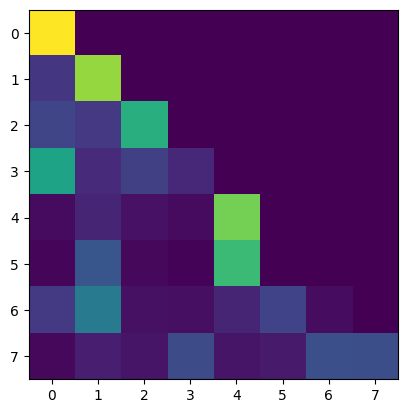

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(wei[0].tolist())
wei[0] # 1st batch (chunk of text, length block_size) only

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
import torch; th = torch
import torch.nn as nn

class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100)    # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std()     # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std(), x[0,:].shape   # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000), torch.Size([100]))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

## Attention Architecture

In [ ]:
# hyperparameters
import torch; th = torch
vocab_size = len(chars)
batch_size = 32  # how many independent sequences will we process in parallel?
block_size = 20 # what is the maximum context length for predictions?
max_iters  = 5000
eval_interval = 100
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd  = 32
n_head  = 8
n_layer = 4
dropout = 0.0
vocab_size

39

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)

    def forward(self, x):
      x = x + self.sa(  self.ln1(x))
      x = x + self.ffwd(self.ln2(x))
      return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, n_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),        )

    def forward(self, x):
        return self.net(x)

class BigramLanguageModel(nn.Module):

    def __init__(self):
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
      self.position_embed_table  = nn.Embedding(block_size, n_embd)
      # self.ffwd = FeedFoward(n_embd)
      self.heads = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_head)])
      self.ln_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
       B, T = idx.shape

       tkn_emb = self.token_embedding_table(idx)         # (B, T, C=emb) logits --> tkn_emb
       pos_emb = self.position_embed_table(th.arange(T)) #, device=device)  # T = idx.shape[1]
       x       = tkn_emb + pos_emb
       logits  = self.ln_head(x)           # (B, T, C=vocab)
       if targets is None: loss = None
       else:
          _, _, C = logits.shape
          logits  = logits.view(B*T, C)
          targets = targets.view(B*T)

          loss = F.cross_entropy(logits, targets)
       return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is (B, T) array of indices in the current context
      for _ in range(max_new_tokens):
          # crop idx to the last block_size tokens
          idx_cond = idx[:, -block_size:]
          # get the predictions
          logits, loss = self(idx_cond)
          # focus only on the last time step
          logits = logits[:, -1, :] # becomes (B, C)
          # apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # (B, C)
          # sample from the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # append sampled index to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      return idx

m = BigramLanguageModel()
# m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

0.104039 M parameters


In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

In [ ]:
import time
tik = time.time()
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(time.time()-tik)

step 0: train loss 3.9519, val loss 3.9476
step 100: train loss 3.1146, val loss 3.1167
step 200: train loss 2.8158, val loss 2.8211
step 300: train loss 2.6966, val loss 2.6944
step 400: train loss 2.6243, val loss 2.6284
step 500: train loss 2.5819, val loss 2.5856
step 600: train loss 2.5646, val loss 2.5629
step 700: train loss 2.5330, val loss 2.5328
step 800: train loss 2.5214, val loss 2.5226
step 900: train loss 2.5119, val loss 2.5096
step 1000: train loss 2.4977, val loss 2.5042
step 1100: train loss 2.4926, val loss 2.4937
step 1200: train loss 2.4859, val loss 2.4882
step 1300: train loss 2.4844, val loss 2.4899
step 1400: train loss 2.4810, val loss 2.4858
step 1500: train loss 2.4800, val loss 2.4792
step 1600: train loss 2.4754, val loss 2.4733
step 1700: train loss 2.4709, val loss 2.4729
step 1800: train loss 2.4664, val loss 2.4772
step 1900: train loss 2.4710, val loss 2.4770
step 2000: train loss 2.4635, val loss 2.4754
step 2100: train loss 2.4619, val loss 2.4655


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long) #, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


yani:
t


tomathan,
layodsoshat lingor abseseret dino m:

f s y chemis nd is tey s th e.

fupr:

far t! or: ces, whe bl d buloke f getherasyo m;
hyothedenkts at wengoponge to:
we whrs a





is ld, akendanthavesinanches cus an borkis t tr alofak d me. ieeth acheicn my be,
l.
is tinth mt rdndgs, apf it th a

o ave y fatie
ingld cad, hone sotheweramys whan y th buk,
ke nd sharinglapllll t hershepa t ghawiul p ant y apu chit:
abithe mfo wnear gce f wrobafiron tor is mise no woay ariyoout sari jy el


### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
# @title Long code
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4198, val loss 2.4340
step 400: train loss 2.3503, val loss 2.3567
step 500: train loss 2.2970, val loss 2.3136
step 600: train loss 2.2410, val loss 2.2506
step 700: train loss 2.2062, val loss 2.2198
step 800: train loss 2.1638, val loss 2.1871
step 900: train loss 2.1232, val loss 2.1494
step 1000: train loss 2.1020, val loss 2.1293
step 1100: train loss 2.0704, val loss 2.1196
step 1200: train loss 2.0382, val loss 2.0798
step 1300: train loss 2.0249, val loss 2.0640
step 1400: train loss 1.9922, val loss 2.0354
step 1500: train loss 1.9707, val loss 2.0308
step 1600: train loss 1.9614, val loss 2.0474
step 1700: train loss 1.9393, val loss 2.0130
step 1800: train loss 1.9070, val loss 1.9943
step 1900: train loss 1.9057, val loss 1.9871
step 2000: train loss 1.8834, val loss 1.9954
step 2100: train loss 1.